### HW_06 Embedding
> **Обучить сиамскую сеть для верификации лиц на датасете LFW**

In [2]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.version.VERSION)

2.3.0-dev20200608


In [3]:
# кастомные настройки
# установка GPU на котором будем работать
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Загрузка датасета LFW

In [4]:
ds, ds_info = tfds.load('lfw', 
                        split='train', 
                        shuffle_files=True,
                        with_info=True,
                       )

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [6]:
test = ds.take(1)
for example in test:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  label = label.numpy().decode('utf-8')
  print(image.shape, label)

['image', 'label']
(250, 250, 3) Kimi_Raikkonen


## Визуализация датасета 

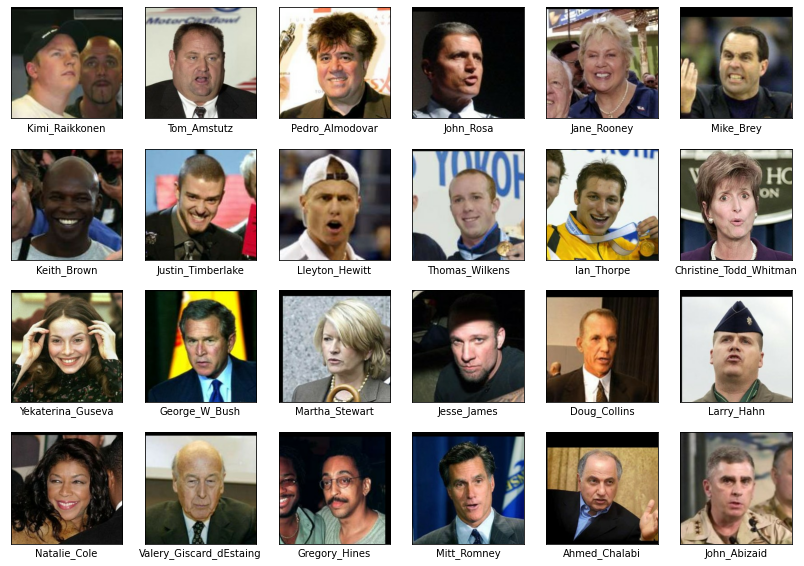

In [7]:
train_ds = ds
fig = plt.figure(figsize=(14, 10))

for j, example in enumerate(train_ds.take(24)):
    image, label = example["image"],  example["label"]
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(image)
    label = label.numpy().decode("utf-8")
    ax.set_xlabel(label)
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [8]:
NUM_EPOCHS = 5
BATCH_SIZE = 2
INP_SIZE = 250

In [9]:
def img_prep(img):
    img = tf.cast(img, tf.float32)/255.
    return img

def prepare(img):
    img['image'] = img_prep(img['image'])
    return img

In [10]:
train_ds = ds
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
# train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.batch(BATCH_SIZE)

## Создание модели CNN

In [11]:
EMB_SIZE = 128

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
#     tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
#     tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
#     tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
#     tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
#     tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(EMB_SIZE, activation=None),
# ])

In [12]:
# Transfer Learning
base_model = tf.keras.applications.Xception(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True # Fine-tuning весов предобученной модели

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [13]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    loss = tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)
    
    print(f'd={d}, z={z}, loss={loss}')
    return loss

## Подготовка к обучению

In [14]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [15]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [16]:
%%time

for iteration, item in enumerate(train_ds):
    images, labels = item['image'], item['label']
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 50 == 0:
        print('[{}] Labels: {}'.format(iteration, labels.numpy()))
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

d=[2.4198742], z=[0.]
[0] Labels: [b'Gray_Davis' b'Wen_Jiabao']
[0] Loss: 57.45830535888672
d=[9.626856], z=[0.]
d=[11.881071], z=[0.]
d=[44.09941], z=[0.]
d=[37.014084], z=[0.]
d=[21.762838], z=[0.]
d=[24.728529], z=[0.]
d=[62.41131], z=[0.]
d=[95.69649], z=[0.]
d=[115.769035], z=[0.]
d=[105.297554], z=[0.]
d=[149.03351], z=[0.]
d=[241.25737], z=[0.]
d=[216.4526], z=[0.]
d=[247.34627], z=[0.]
d=[225.46242], z=[0.]
d=[137.78203], z=[0.]
d=[119.7118], z=[0.]
d=[322.57996], z=[0.]
d=[251.62831], z=[0.]
d=[69.28629], z=[0.]
d=[327.8759], z=[0.]
d=[1009.31464], z=[0.]
d=[3010.8945], z=[0.]
d=[419.68573], z=[0.]
d=[624.37286], z=[0.]
d=[371.08072], z=[0.]
d=[1593.3533], z=[0.]
d=[589.84], z=[0.]
d=[315.02255], z=[0.]
d=[3058.6501], z=[0.]
d=[1555.8279], z=[0.]
d=[1356.9358], z=[0.]
d=[812.6145], z=[0.]
d=[771.97925], z=[0.]
d=[452.45508], z=[0.]
d=[394.28168], z=[0.]
d=[711.62415], z=[0.]
d=[464.66763], z=[0.]
d=[1079.3694], z=[0.]
d=[216.87094], z=[0.]
d=[286.4945], z=[0.]


KeyboardInterrupt: 

In [17]:
tf.get_logger().setLevel(logging.DEBUG)

## Запуск предсказания на нашем изображении

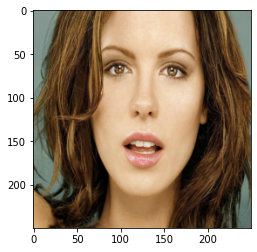

In [18]:
import imageio
from skimage.transform import resize
INP_SIZE = 250

def prepare_image(img):
    img = img.astype(np.float32)/255.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

img = imageio.imread('03_1.jpg', pilmode="RGB")
img = prepare_image(img)
plt.imshow(img)


## Тестирование на новых данных

In [19]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250), order=3, mode='constant', anti_aliasing=True)
#     img = (1. - img).astype(np.float32)
#     img = np.mean(img, axis=2)
#     img = np.reshape(img, (250, 250, 1))
    return img

img_a1 = load_and_prepare_image('03_1.jpg')
img_a2 = load_and_prepare_image('03_2.jpg')
img_a3 = load_and_prepare_image('01_3.jpg')
img_a4 = load_and_prepare_image('03_4.jpg')

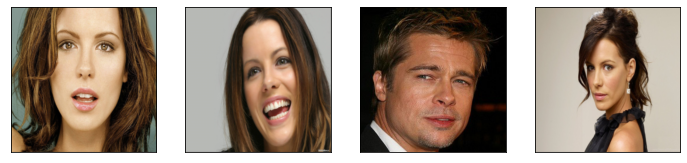

In [20]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_a3)
plt.xticks([]), plt.yticks([])
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_a4)
plt.xticks([]), plt.yticks([])
plt.show()

## Получение эмбеддингов для новых данных

In [21]:
# new_embs = model(np.stack((img_a1, img_a2, img_a3, img_a4), axis=0))

# emb1 = new_embs[0,:]
# emb2 = new_embs[1,:]
# emb3 = new_embs[2,:]
# emb4 = new_embs[3,:]
img = img_a1[tf.newaxis,:]
# img = np.stack((img_a1, img_a2, img_a3, img_a4), axis=0)
img.shape

emb1 =  model(img)
# emb2 = new_embs[1,:]
# emb3 = new_embs[2,:]
# emb4 = new_embs[3,:]

## Вычисление расстояний между эмбеддингами

In [22]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5


print('A1 <-> A2: ', diff(emb1, emb2))
print('A1 <-> A3: ', diff(emb1, emb3))
print('A1 <-> A4: ', diff(emb1, emb4))
print('A2 <-> A3: ', diff(emb2, emb3))
print('A2 <-> A4: ', diff(emb2, emb4))
print('A3 <-> A4: ', diff(emb3, emb4))

NameError: name 'emb2' is not defined